In [1]:
!pip install silence_tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.2-py3-none-any.whl size=5827 sha256=4a1c9b0ce395ce397190b3838f57d8058762070792dcc5df7f6609ee13c78139
  Stored in directory: /root/.cache/pip/wheels/4e/e1/85/e501d21f8d79832caa65e1b779bc17d1847ebc0170f7bc5a80
Successfully built silence_tensorflow


In [2]:
# A function to avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [3]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

**DATA PREPERATION**

In [6]:
# prompt: CODE DOWNLOAD THIS DATASET FROM KAGGLE OF DIRECTORY kritikseth/fruit-and-vegetable-image-recognition

!kaggle datasets download -d swoyam2609/fresh-and-stale-classification


Dataset URL: https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification
License(s): Community Data License Agreement - Permissive - Version 1.0
 99% 2.83G/2.84G [00:17<00:00, 202MB/s]
100% 2.84G/2.84G [00:18<00:00, 169MB/s]


In [7]:
base_dir = '/content/drive/MyDrive/CNN/dataset'

In [8]:
train_dir = os.path.join(base_dir, '/content/drive/MyDrive/CNN/dataset/Train')
validation_dir = os.path.join(base_dir, '/content/drive/MyDrive/CNN/dataset/Test')
test_dir = os.path.join(base_dir, '/content/drive/MyDrive/CNN/dataset/Test')

In [9]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CNN/dataset/Train'

In [ ]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [ ]:
num_of_classes(train_dir, '/content/drive/MyDrive/CNN/dataset/Train')
num_of_classes(validation_dir, '/content/drive/MyDrive/CNN/dataset/Test')
num_of_classes(test_dir, '/content/drive/MyDrive/CNN/dataset/Test')

number of classes in /content/drive/MyDrive/CNN/dataset/Train folder : 14
number of classes in /content/drive/MyDrive/CNN/dataset/Test folder : 14
number of classes in /content/drive/MyDrive/CNN/dataset/Test folder : 14


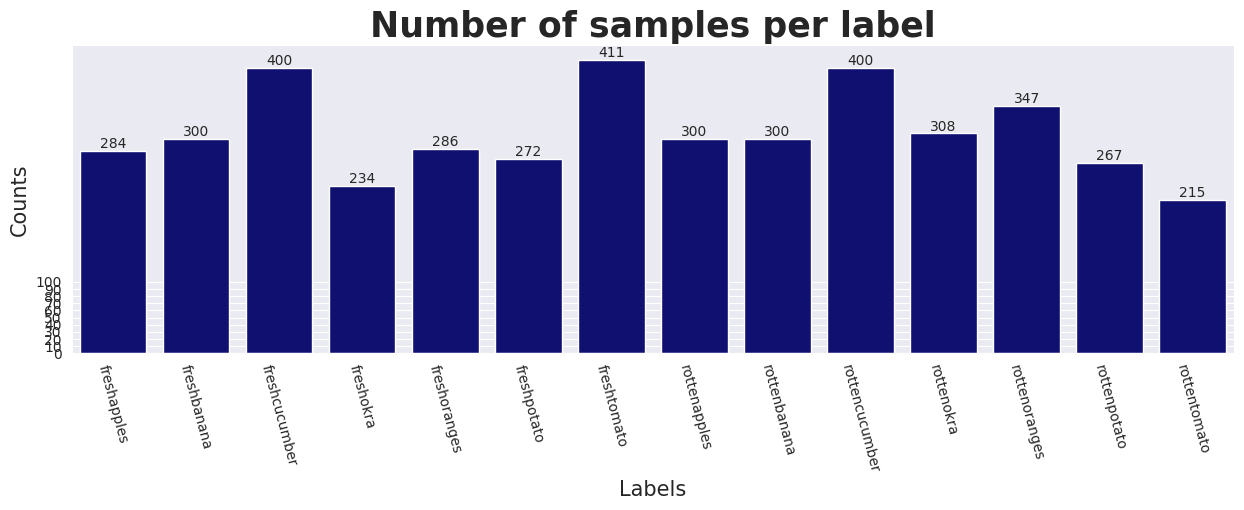

In [ ]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

In [ ]:
def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [ ]:
def create_df(folder_path):
    """Creates a DataFrame with file paths and labels.

    This function now determines the classes directly from the provided folder path
    instead of relying on a global variable.

    Args:
        folder_path (str): The path to the folder containing the image data.

    Returns:
        pd.DataFrame: A DataFrame with columns 'file_path' and 'label'.
    """
    all_images = []
    # Get classes directly from the folder path
    classes = [class_name for class_name in os.listdir(folder_path)]
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [ ]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [ ]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 4324
Number of samples in validation : 3985
Number of samples test : 3985


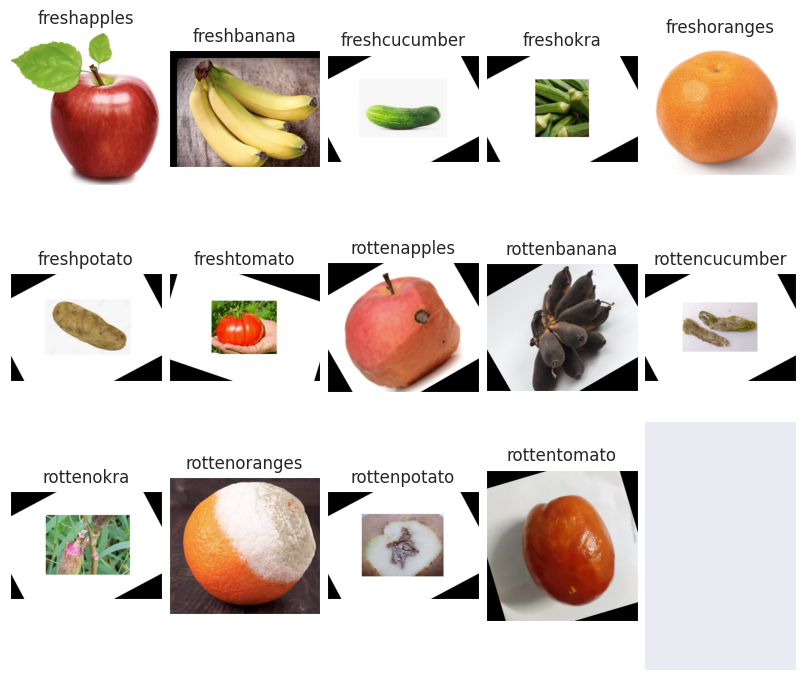

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

# Limit the iteration to the number of unique labels
for i, ax in enumerate(axes.flat):
    # Break the loop if we've displayed all unique labels
    if i >= len(df_unique):
        break
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,

)

Found 4324 validated image filenames belonging to 14 classes.


In [ ]:
# validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 3985 validated image filenames belonging to 14 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 3985 validated image filenames belonging to 14 classes.


In [ ]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

In [ ]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [ ]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))

# Build the model by specifying the input shape
# This is necessary since we haven't called fit() yet
model.build(input_shape=(None, 224, 224, 3)) # 'None' represents the batch size

plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# Compile
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
# Change the number of units in the final Dense layer to 14, or whatever the actual number of classes in your dataset is.
model.add(layers.Dense(14, activation='softmax')) # Assuming 14 classes

# Build the model by specifying the input shape
# This is necessary since we haven't called fit() yet
model.build(input_shape=(None, 224, 224, 3)) # 'None' represents the batch size

plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# Compile
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
print("Model compiled successfully!") # Add this line for verification

Model compiled successfully!


In [ ]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Ensure validation_generator yields data by checking its contents
# For example, you can try iterating through it and printing a few samples:

# Print some samples from validation_generator
for i in range(5):
  X_val_sample, y_val_sample = next(validation_generator)
  print(f"Validation sample {i+1}: X_shape={X_val_sample.shape}, y_shape={y_val_sample.shape}")

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

NameError: name 'ModelCheckpoint' is not defined

In [ ]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
# Change the number of units in the output layer to 18
model.add(layers.Dense(18, activation='softmax')) # Changed from 36 to 18

# Build the model by specifying the input shape
# This is necessary since we haven't called fit() yet
model.build(input_shape=(None, 224, 224, 3)) # 'None' represents the batch size

plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it
best_model = models.load_model('MyModel.keras')

In [ ]:
test_loss, test_acc = best_model.evaluate_generator(test_generator)

print(colored(f'Test Loss : {round(test_loss, 3)}', 'green', attrs=['bold']))
print(colored(f'Test Accuracy : {round(test_acc, 3)}', 'green', attrs=['bold']))

Test Loss : 0.056
Test Accuracy : 0.988


In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

125/125 [==============================] - 34s 267ms/step
                precision    recall  f1-score   support

   freshapples       0.99      0.99      0.99       362
   freshbanana       1.00      1.00      1.00       332
 freshcucumber       0.99      1.00      0.99       279
     freshokra       1.00      0.98      0.99       300
  freshoranges       1.00      0.99      0.99       300
   freshpatato       0.98      0.94      0.96       270
    freshtamto       1.00      1.00      1.00       255
  rottenapples       0.99      0.98      0.98       257
  rottenbanana       1.00      1.00      1.00       212
rottencucumber       0.98      0.99      0.99       255
    rottenokra       0.99      1.00      0.99       200
 rottenoranges       0.98      0.99      0.99       300
  rottenpatato       0.95      0.98      0.97       340
   rottentamto       1.00      1.00      1.00       323

      accuracy                           0.99      3985
     macro avg       0.99      0.99      0.9

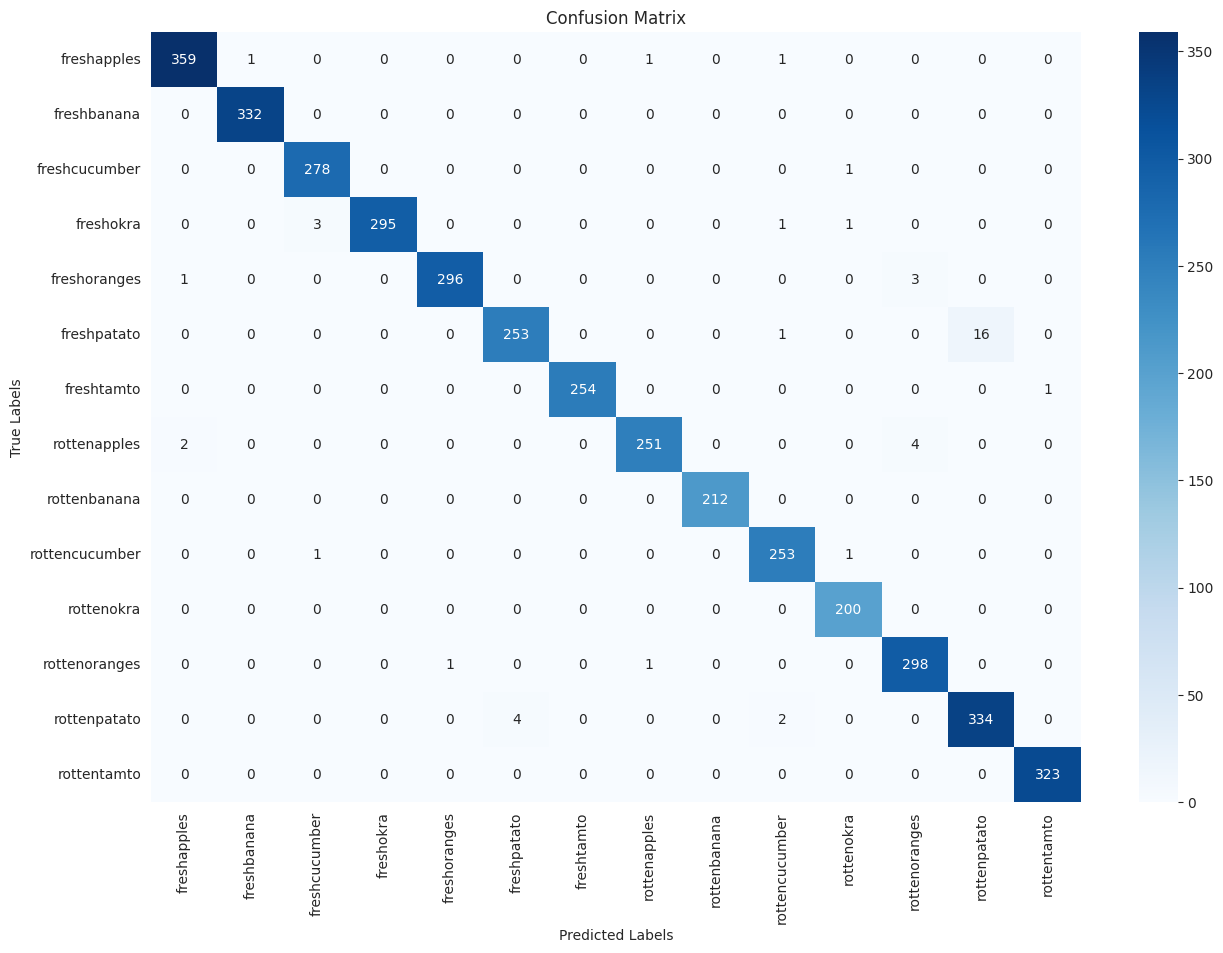

In [ ]:
evaluate_model_performance(best_model, validation_generator, classes)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image  # Import the image module

def predict_image_class(image_path):
  """
  Predicts the class of an image using the best_model.

  Args:
    image_path: The path to the image file.

  Returns:
    The predicted class label.
  """
  img_width, img_height = 224, 224  # Replace with the input size of your model

  img = image.load_img(image_path, target_size=(img_width, img_height))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img / 255.

  predictions = best_model.predict(img)
  predicted_class_index = np.argmax(predictions[0])
  predicted_class_label = list(train_generator.class_indices.keys())[predicted_class_index]

  return predicted_class_label


# Example usage:
image_path = '/content/drive/MyDrive/CNN/dataset/Train/rottencucumber/c_r001.png'
predicted_class = predict_image_class(image_path)
print(f"The predicted class for the image is: {predicted_class}")

1/1 [==============================] - 1s 753ms/step
The predicted class for the image is: rottencucumber


1/1 [==============================] - 0s 45ms/step
The predicted class for the image is: freshtomato


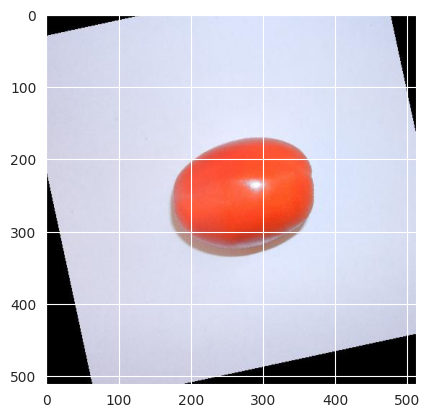

In [ ]:
image_path = '/content/drive/MyDrive/CNN/dataset/Train/freshtomato/DSCN4068.jpg_0_1422.jpg'
print_img = image.load_img(image_path)
plt.imshow(print_img)
predicted_class = predict_image_class(image_path)
print(f"The predicted class for the image is: {predicted_class}")

1/1 [==============================] - 0s 46ms/step
The predicted class for the image is: rottencucumber


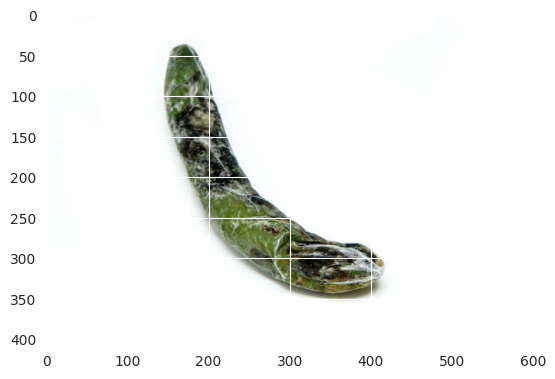

In [ ]:
image_path = '/content/istockphoto-1445808546-612x612.jpg'
print_img = image.load_img(image_path)
plt.imshow(print_img)
predicted_class = predict_image_class(image_path)
print(f"The predicted class for the image is: {predicted_class}")

1/1 [==============================] - 0s 43ms/step
The predicted class for the image is: rottenoranges


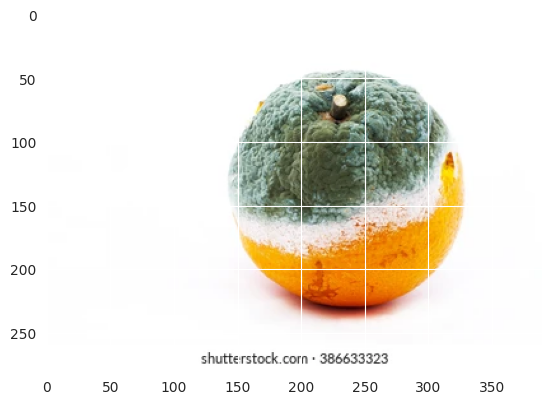

In [ ]:
image_path = '/content/rotten-oranges-260nw-386633323.webp'
print_img = image.load_img(image_path)
plt.imshow(print_img)
predicted_class = predict_image_class(image_path)
print(f"The predicted class for the image is: {predicted_class}")

In [ ]:
# export the best_model which is trained to save offline

best_model.save('my_fruit_vegetable_model.h5')
!zip -r my_fruit_vegetable_model.zip my_fruit_vegetable_model.h5
from google.colab import files
files.download('my_fruit_vegetable_model.zip')


  adding: my_fruit_vegetable_model.h5 (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 43ms/step
The predicted class for the image is: rottenbanana


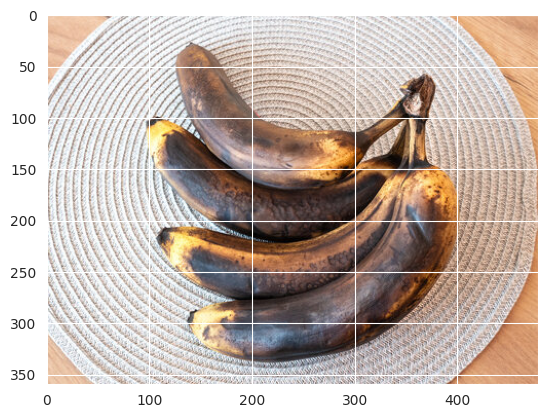

In [ ]:
image_path = '/content/360_F_416076504_dqP3neX6EQk6GV5Ngbg7pCNdYJyEBfre.jpg'
print_img = image.load_img(image_path)
plt.imshow(print_img)
predicted_class = predict_image_class(image_path)
print(f"The predicted class for the image is: {predicted_class}")

In [ ]:
image_path = '/content/360_F_416076504_dqP3neX6EQk6GV5Ngbg7pCNdYJyEBfre.jpg'
print_img = image.load_img(image_path)
plt.imshow(print_img)
predicted_class = predict_image_class(image_path)
print(f"The predicted class for the image is: {predicted_class}")

1/1 [==============================] - 0s 47ms/step
The predicted class for the image is: rottenpotato


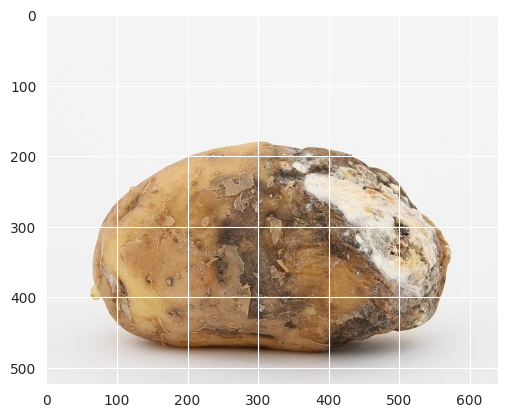

In [ ]:
image_path = '/content/age-1238308_640.jpg'
print_img = image.load_img(image_path)
plt.imshow(print_img)
predicted_class = predict_image_class(image_path)
print(f"The predicted class for the image is: {predicted_class}")

1/1 [==============================] - 0s 51ms/step
The predicted class for the image is: freshokra


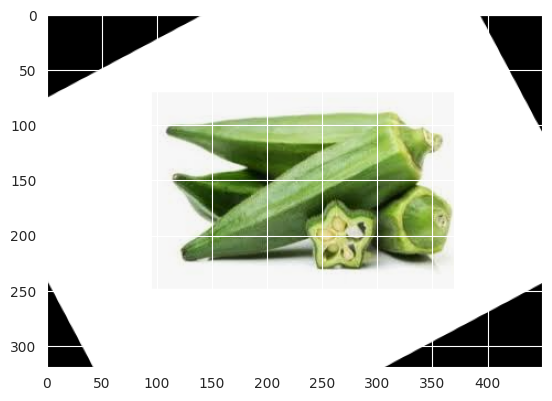

In [ ]:
image_path = '/content/drive/MyDrive/CNN/dataset/Test/freshokra/o_f002.png'
print_img = image.load_img(image_path)
plt.imshow(print_img)
predicted_class = predict_image_class(image_path)
print(f"The predicted class for the image is: {predicted_class}")

In [ ]:
image_path = '/content/age-1238308_640.jpg'
print_img = image.load_img(image_path)
plt.imshow(print_img)
predicted_class = predict_image_class(image_path)
print(f"The predicted class for the image is: {predicted_class}")

NameError: name 'image' is not defined